In [1]:
from __future__ import print_function
import numpy as np
import torch

In [2]:
pmtpos = np.load("/home/lukasb/watchmal/IWCD_mPMT_image_positions.npz")

In [7]:
print(list(pmtpos.keys()))

['mpmt_image_positions']


In [9]:
print(pmtpos['mpmt_image_positions'].shape)
print(pmtpos['mpmt_image_positions'])

(832, 2)
[[26  0]
 [26  1]
 [26  2]
 ...
 [38 17]
 [39 20]
 [39 19]]


from what I understand, these are the x/y coordinates in the grid for each mPMT ID, given by (tubeId-1)//19

In [11]:
np.amax(pmtpos['mpmt_image_positions'],0)

array([39, 39], dtype=int16)

In [24]:
grid = np.zeros((40,40))
mpmtno = np.zeros((40,40))
mpmtno -= 1
for mpmt in range(pmtpos['mpmt_image_positions'].shape[0]):
    idx = pmtpos['mpmt_image_positions'][mpmt,:]
    grid[idx[0],idx[1]] = 1.
    mpmtno[idx[0],idx[1]] = mpmt

In [17]:
from __future__ import print_function
import numpy as np
import torch 
import h5py
import matplotlib.pyplot as plt
%matplotlib inline

def imshowRdBu(ax,img):
    minmax = max(torch.max(img),-torch.min(img))
    return ax.imshow(-img,cmap='RdBu',vmin=-minmax,vmax=minmax)

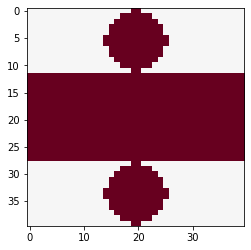

In [23]:
imshowRdBu(plt, torch.tensor(grid))

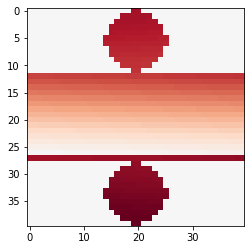

In [25]:
imshowRdBu(plt, torch.tensor(mpmtno))

In [29]:
# pmtpos = np.load("/home/lukasb/watchmal/IWCD_mPMT_image_positions.npz")
np.savetxt("/home/lukasb/watchmal/IWCD_mPMT_image_positions.csv", pmtpos['mpmt_image_positions'], fmt='%d', delimiter=',')

In [ ]:
print(x.grad)

In [ ]:
z = y.mean()

In [ ]:
z.backward()

In [ ]:
print(x.grad)

In [ ]:
print(x)

In [ ]:
print(y)

In [30]:
f = h5py.File('/home/lukasb/watchmal/data/IWCDmPMT_4pi_full_tank/h5_opencan/e-/IWCDmPMT_4pi_full_tank_e-_E0to1000MeV_unif-pos-R371-y521cm_4pi-dir_3000evts_1.h5','r')
event_data = f['event_data'][:]

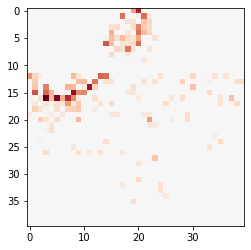

In [45]:
imshowRdBu(plt, torch.tensor(event_data[2,:,:,10]))

## load a network and say if we can compute the gradient of the loss on the data

from `20200708-04-IWCD-SmallerResNetGeom-timeCmplx`

In [ ]:
from __future__ import print_function
import numpy as np
import torch 
import h5py
import matplotlib.pyplot as plt
%matplotlib inline

def geometricPad(grid, pad=1):
  M = grid.shape[2]; # 0:batchsize, 1:channels, 2:width, 3:height
  M_new = pad+M+pad;
  new_shape = (grid.shape[0], grid.shape[1], M_new, M_new)
  grid_new = grid.new_zeros(new_shape);
  grid_new[:,:,pad:M+pad,pad:M+pad] = grid;
  grid_new[:,:,0:pad,pad:(M+pad)] = grid[:,:,:,0:pad].flip(-1).transpose(-1,-2);
  grid_new[:,:,pad:(M+pad),0:pad] = grid[:,:,0:pad,:].flip(-2).transpose(-1,-2);
  grid_new[:,:,(M+pad):(M+pad+pad),(pad):(M+pad)] = grid[:,:,:,(M-pad):].flip(-1).transpose(-1,-2);
  grid_new[:,:,pad:(M+pad),(M+pad):(M+pad+pad)] = grid[:,:,(M-pad):,:].flip(-2).transpose(-1,-2);
  return(grid_new);

In [ ]:
f = h5py.File('/home/lukasb/watchmal/data/IWCDmPMT_4pi_full_tank/h5_topo/IWCDmPMT_4pi_full_tank_e-_E0to1000MeV_unif-pos-R371-y521cm_4pi-dir_3000evts_1.h5','r')
event_data = f['event_data'][:]

In [ ]:
def imshowRdBu(ax,img):
    minmax = max(torch.max(img),-torch.min(img))
    return ax.imshow(-img,cmap='RdBu',vmin=-minmax,vmax=minmax)

In [ ]:
from torch.utils.data import Dataset, DataLoader

class H5Dataset(Dataset):

    def __init__(self, files, transform=None, flavour=None, limit_num_files=0, start_fraction=0., use_fraction=1.0):
        """                                                                                                                                             
        Args: data_dirs ... a list of data directories to find files (up to 10 files read from each dir)                                                
              transform ... a function applied to pre-process data                                                                                      
              flavour ..... a string that is required to be present in the filename                                                                     
              limit_num_files ... an integer limiting number of files to be taken per data directory                                                    
              start_fraction ... a floating point fraction (0.0=>1.0) to specify which entry to start reading (per file)                                
              use_fraction ..... a floating point fraction (0.0=>1.0) to specify how much fraction of a file to be read out (per file)                  
        """
        self._transform = transform
        self._files = []

        # Check input fractions makes sense                                                                                                             
        assert start_fraction >= 0. and start_fraction < 1.
        assert use_fraction > 0. and use_fraction <= 1.
        assert (start_fraction + use_fraction) <= 1.

        # Load files (up to 10) from each directory in data_dirs list                                                                                   
        # for d in data_dirs:
        #     file_list = [ os.path.join(d,f) for f in os.listdir(d) if flavour is None or flavour in f ]
        #     if limit_num_files: file_list = file_list[0:limit_num_files]
        #     self._files += file_list
        self._files = files

        self._file_handles = [None] * len(self._files)
        self._event_to_file_index  = []
        self._event_to_entry_index = []
        import h5py
        for file_index, file_name in enumerate(self._files):
            f = h5py.File(file_name,mode='r')
            data_size = f['event_data'].shape[0]
            start_entry = int(start_fraction * data_size)
            num_entries = int(use_fraction * data_size)
            self._event_to_file_index += [file_index] * num_entries
            self._event_to_entry_index += range(start_entry, start_entry+num_entries)
            f.close()

    def __len__(self):
        return len(self._event_to_file_index)

    def __getitem__(self,idx):
        file_index = self._event_to_file_index[idx]
        entry_index = self._event_to_entry_index[idx]
        if self._file_handles[file_index] is None:
            import h5py
            self._file_handles[file_index] = h5py.File(self._files[file_index],mode='r')
        fh = self._file_handles[file_index]
        label = fh['labels'][entry_index]
        #labelTranslation = [-1,0,1,-1,2] # make sure that labels 1,2,4 get values 0,1,2
        if label == 1: # electron
            label = 0
        elif label == 2: # muon
            label = 1
        elif label == 0: # gamma
            label = 2
        else:
            print('Unknown label', label, 'for entry_index', entry_index, 'treating as label=0')
            label = 0
        
        # try:
        #     label = labelTranslation[label]
        # except IndexError:
        #     print('IndexError at entry', entry_index, 'label in file was', fh['labels'][entry_index], 'translations are', labelTranslation)
        #     raise
        
        event_data = fh['event_data'][entry_index]
        # convert event data to complex rep
        evQ = event_data[:,:,0]
        evT = event_data[:,:,1]
        evR = np.power(evQ,0.25);
        evA = 2*np.pi*(evT-960.)/(1900.-600.)
        evX = evR*np.cos(evA);
        evY = evR*np.sin(evA);
        return np.stack([evX,evY],2),label,idx,fh['positions'][entry_index,0],fh['directions'][entry_index,0],np.sum(fh['energies'][entry_index,:])
        # the ,0 in positions and directions selects the pos/dir for the first track (in case of gamma)
        # thus positions and directions are just np arrays with 3 elements

def HKCollate(batch):
    data  = np.stack([sample[0] for sample in batch])
    label = [sample[1] for sample in batch]
    idx   = [sample[2] for sample in batch]
    pos   = np.stack([sample[3] for sample in batch])
    direc = np.stack([sample[4] for sample in batch])
    ene   = np.stack([sample[5] for sample in batch])
    return data,label,idx,pos,direc,ene

In [ ]:
mcdir = '/home/lukasb/watchmal/data/IWCDmPMT_4pi_full_tank/h5_topo'
pnames = ('e-','mu-')
files = ['%s/%s/IWCDmPMT_4pi_full_tank_%s_E0to1000MeV_unif-pos-R371-y521cm_4pi-dir_3000evts_%d.h5' % (mcdir,pname,pname,bch+100) for bch in range(60) for pname in pnames]

train_ds = H5Dataset(files,start_fraction=0.0,use_fraction=0.9);
test_ds  = H5Dataset(files,start_fraction=0.9,use_fraction=0.1);

# for training
train_loader=DataLoader(train_ds,batch_size=32,shuffle=True,num_workers=4,collate_fn=HKCollate)
# for validation
test_loader =DataLoader( test_ds,batch_size=64,shuffle=True,num_workers=2,collate_fn=HKCollate)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# based on https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py

class BasicGeomBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicGeomBlock, self).__init__()
        
        self.pad = 1
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=2*self.pad+1, stride=stride, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=2*self.pad+1,
                               stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(geometricPad(x,self.pad))))
        out = self.bn2(self.conv2(geometricPad(out,self.pad)))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNetGeom(nn.Module):
    def __init__(self, block, num_blocks, num_classes=3):
        super(ResNetGeom, self).__init__()
        self.in_planes = 64
        overall_in_planes = 2 ## this has been modified to include time
        self.pad = 1
        
        # (1,126,126)
        self.conv1 = nn.Conv2d(overall_in_planes, 32, kernel_size=2*self.pad+1,
                               stride=2, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        # outsize = floor[(126+2*self.pad-3)/stride + 1]
        # so for stride=1 we have 126,
        #              =2          63 = floor(63.5)
        # the padding is done by geometricPad
        # thus (16,63,63)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=2*self.pad+1,
                               stride=2, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        # outsize = floor[(63+2*self.pad-3)/stride + 1]
        # so for stride=1 we have 63,
        #              =2         32
        # thus (64,32,32)
        self.layer1 = self._make_layer(block,  64, num_blocks[0], stride=1)
        #      (64,32,32)
        self.layer2 = self._make_layer(block,  64, num_blocks[1], stride=2)
        #      (64,16,16)
        self.layer3 = self._make_layer(block,  64, num_blocks[2], stride=2)
        #      (64, 8, 8)
        self.layer4 = self._make_layer(block, 128, num_blocks[3], stride=2)
        #      (128,4, 4)
        self.convbn5 = nn.Sequential(
            nn.Conv2d(128,128,kernel_size=4,stride=1,padding=0),
            nn.BatchNorm2d(128)
        )
        #      (128,1, 1)
        # transform to 128, then
        self.linear1 = nn.Linear(int(128*block.expansion),   int(128*block.expansion/2))
        self.linear2 = nn.Linear(int(128*block.expansion/2), int(128*block.expansion/4))
        self.linear3 = nn.Linear(int(128*block.expansion/4), int(128*block.expansion/8))
        self.linear4 = nn.Linear(int(128*block.expansion/8), num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(geometricPad(x,self.pad))))
        out = F.relu(self.bn2(self.conv2(geometricPad(out,self.pad))))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.relu(self.convbn5(out))
        #out = F.avg_pool2d(out, out.shape[2:4])
        out = out.view(out.size(0), -1)
        out = F.relu(self.linear1(out))
        out = F.relu(self.linear2(out))
        out = F.relu(self.linear3(out))
        out = self.linear4(out)
        return out

#    # I'm not sure why I need to implement cpu/cuda myself, train works somehow
#    
#    def cpu(self):
#        super(GeomCNN, self).cpu()
#        for module in self._feature:
#            module.cpu()
#        for module in self._classifier:
#            module.cpu()
#        return self
#    
#    def cuda(self):
#        super(GeomCNN, self).cuda()
#        for module in self._feature:
#            module.cuda()
#        for module in self._classifier:
#            module.cuda()
#        return self

def ResNetGeom18(num_classes):
    return ResNetGeom(BasicGeomBlock, [2, 2, 2, 2], num_classes)

In [ ]:
def forward(blob,train=True):
    """
       Args: blob should have attributes, net, criterion, softmax, data, label
       Returns: a dictionary of predicted labels, softmax, loss, and accuracy
    """
    with torch.set_grad_enabled(train):
        # Prediction
        blob.formatted_data = torch.as_tensor(blob.data).cuda()#[torch.as_tensor(d).cuda() for d in blob.data]
        blob.formatted_data = blob.formatted_data.permute(0,3,1,2)
        prediction = blob.net(blob.formatted_data)
        # Training
        loss,acc=-1,-1
        if blob.label is not None:
            label = torch.as_tensor(blob.label).type(torch.LongTensor).cuda()#[torch.as_tensor(l).cuda() for l in blob.label]
            #label = torch.as_tensor(blob.label).type(torch.FloatTensor).cuda()#[torch.as_tensor(l).cuda() for l in blob.label]
            label.requires_grad = False
            loss = blob.criterion(prediction,label)
        blob.loss = loss
        
        softmax    = blob.softmax(prediction).cpu().detach().numpy()
        prediction = torch.argmax(prediction,dim=-1)
        accuracy   = (prediction == label).sum().item() / float(prediction.nelement())
        # mse        = blob.mse(prediction,label).cpu().detach().numpy()
        # accuracy   = np.sqrt(mse.mean()).item()
        prediction = prediction.cpu().detach().numpy()
        
        return {'prediction' : prediction,
                'softmax'    : softmax,
                'loss'       : loss.cpu().detach().item(),
                'accuracy'   : accuracy}

def backward(blob):
    blob.optimizer.zero_grad()  # Reset gradients accumulation
    blob.loss.backward()
    blob.optimizer.step()

def save_state(blob):
    # Output file name
    filename = '%s-%d.ckpt' % (blob.prefix, blob.iteration)
    # Save parameters
    # 0+1) iteration counter + optimizer state => in case we want to "continue training" later
    # 2) network weight
    torch.save({
        'global_epoch': blob.epoch,
        'global_step': blob.iteration,
        'optimizer': blob.optimizer.state_dict(),
        'state_dict': blob.net.state_dict()
        }, filename)
    return filename

def restore_state(blob, iteration):
    # Open a file in read-binary mode
    weight_file = '%s-%d.ckpt' % (blob.prefix, iteration)
    with open(weight_file, 'rb') as f:
        # torch interprets the file, then we can access using string keys
        checkpoint = torch.load(f)
        # load network weights
        blob.net.load_state_dict(checkpoint['state_dict'], strict=False)
        # if optimizer is provided, load the state of the optimizer
        if blob.optimizer is not None:
            blob.optimizer.load_state_dict(checkpoint['optimizer'])
        # load iteration count
        blob.epoch     = checkpoint['global_epoch']
        blob.iteration = checkpoint['global_step']

# weight_file = save_state(blob, '20190819-02-DeepTaylor-01-BatchNorm')
# print('Saved to', weight_file)


# # Recreate the network (i.e. initialize)
# blob.net=LeNet().cuda()
# # Get one batch of data to test
# blob.data, blob.label = next(iter(train_loader))
# # Run forward function
# res = forward(blob,True)
# # Report
# print('Accuracy:',res['accuracy'])



# # Restore the state
# restore_state(weight_file,blob)
# # Run the forward function
# res = forward(blob,True)
# # Report
# print('Accuracy',res['accuracy'])

In [ ]:
class BLOB:
    pass
blob=BLOB()
blob.net       = ResNetGeom18(2).cuda() # construct ResNet for 2 class classification, use GPU
# just the training weights is ~700MiB
blob.criterion = torch.nn.CrossEntropyLoss() # use softmax loss to define an error
blob.optimizer = torch.optim.Adam(blob.net.parameters()) # use Adam optimizer algorithm
blob.softmax   = torch.nn.Softmax(dim=1) # not for training, but softmax score for each class
blob.prefix    = '20200708-04-IWCD-SmallResNetGeom-timeCmplx-01-e-mu'
blob.epoch     = 0.
blob.iteration = 0
blob.data      = None # data for training/analysis
blob.label     = None # label for training/analysis

In [ ]:
restore_state(blob, 40500)

In [ ]:
Nplot = 6
fig, axes = plt.subplots(1, Nplot, figsize=(16,3),facecolor='w')

blob.net.eval()
test_data = next(iter(test_loader))
blob.data,blob.label = test_data[0:2]
blob.data  = blob.data[0:Nplot,:,:,:]
blob.label = blob.label[0:Nplot]
res = forward(blob,True)

for ev in range(int(Nplot/2)):
    for qt in range(2):
        #im = axes[2*ev+qt].imshow(blob.data[ev,:,:,qt])
        imshowRdBu(axes[2*ev+qt], torch.as_tensor(blob.data[ev,:,:,qt]))
        labelNames = ['e','μ']
        correct = (blob.label[ev] == res['prediction'][ev])
        if qt == 0:
            axes[2*ev+qt].set_title('%s pred: %s, true: %s' % ('✔︎' if correct else '✖︎', labelNames[blob.label[ev]], labelNames[res['prediction'][ev]]))
    #cbar = fig.colorbar(im, ax=axes[0])
plt.show()

#del test_data
#del blob.data
#del blob.label

In [ ]:
blob.loss.backward()

In [ ]:
print(blob.formatted_data.shape)
print(blob.formatted_data.grad.shape)

In [ ]:
blob.net.conv1.parameters

In [ ]:
blob.formatted_data.requires_grad

In [ ]:
def forward(blob,train=True,data_requires_grad=False):
    """
       Args: blob should have attributes, net, criterion, softmax, data, label
       Returns: a dictionary of predicted labels, softmax, loss, and accuracy
    """
    with torch.set_grad_enabled(train):
        # Prediction
        blob.formatted_data = torch.as_tensor(blob.data).cuda()#[torch.as_tensor(d).cuda() for d in blob.data]
        blob.formatted_data = blob.formatted_data.permute(0,3,1,2)
        blob.formatted_data.requires_grad = data_requires_grad
        prediction = blob.net(blob.formatted_data)
        # Training
        loss,acc=-1,-1
        if blob.label is not None:
            label = torch.as_tensor(blob.label).type(torch.LongTensor).cuda()#[torch.as_tensor(l).cuda() for l in blob.label]
            #label = torch.as_tensor(blob.label).type(torch.FloatTensor).cuda()#[torch.as_tensor(l).cuda() for l in blob.label]
            label.requires_grad = False
            loss = blob.criterion(prediction,label)
        blob.loss = loss
        
        softmax    = blob.softmax(prediction).cpu().detach().numpy()
        prediction = torch.argmax(prediction,dim=-1)
        accuracy   = (prediction == label).sum().item() / float(prediction.nelement())
        # mse        = blob.mse(prediction,label).cpu().detach().numpy()
        # accuracy   = np.sqrt(mse.mean()).item()
        prediction = prediction.cpu().detach().numpy()
        
        return {'prediction' : prediction,
                'softmax'    : softmax,
                'loss'       : loss.cpu().detach().item(),
                'accuracy'   : accuracy}


In [ ]:
res = forward(blob,True,data_requires_grad=True)

In [ ]:
blob.formatted_data.requires_grad

In [ ]:
blob.loss.backward()

In [ ]:
print(blob.formatted_data.shape)
print(blob.formatted_data.grad.shape)

In [ ]:
fig, axes = plt.subplots(1, Nplot, figsize=(16,3),facecolor='w')
for ev in range(int(Nplot/2)):
    for qt in range(2):
        #im = axes[2*ev+qt].imshow(blob.data[ev,:,:,qt])
        imshowRdBu(axes[2*ev+qt], blob.formatted_data.grad[ev,qt,:,:].cpu())
        labelNames = ['e','μ']
        correct = (blob.label[ev] == res['prediction'][ev])
        if qt == 0:
            axes[2*ev+qt].set_title('%s pred: %s, true: %s' % ('✔︎' if correct else '✖︎', labelNames[blob.label[ev]], labelNames[res['prediction'][ev]]))
    #cbar = fig.colorbar(im, ax=axes[0])
plt.show();

In [ ]:
Nrows = 5
for r in range(Nrows):
    Nplot = 6
    fig, axes = plt.subplots(1, Nplot, figsize=(16,3),facecolor='w')

    blob.net.eval()
    test_data = next(iter(test_loader))
    blob.data,blob.label = test_data[0:2]
    blob.data  = blob.data[0:Nplot,:,:,:]
    blob.label = blob.label[0:Nplot]
    res = forward(blob,True,data_requires_grad=True)
    blob.loss.backward()

    for ev in range(int(Nplot/2)):
        for qt in range(2):
            #im = axes[2*ev+qt].imshow(blob.data[ev,:,:,qt])
            imshowRdBu(axes[2*ev+qt], blob.formatted_data.grad[ev,qt,:,:].cpu())
            labelNames = ['e','μ']
            correct = (blob.label[ev] == res['prediction'][ev])
            if qt == 0:
                axes[2*ev+qt].set_title('%s pred: %s, true: %s' % ('✔︎' if correct else '✖︎', labelNames[blob.label[ev]], labelNames[res['prediction'][ev]]))
        #cbar = fig.colorbar(im, ax=axes[0])
    plt.show()

    del test_data
    del blob.data
    del blob.label

I can probably run the NN layer by layer

In [ ]:
convbn1 = F.relu(blob.net.bn1(blob.net.conv1(geometricPad(blob.formatted_data,blob.net.pad))))

In [ ]:
convbn1.shape

In [ ]:
activation = torch.zeros(convbn1.shape)
activation[:,0,10,10] = 1.
convbn1.backward(activation.cuda())

In [ ]:
fig, axes = plt.subplots(1, Nplot, figsize=(16,3),facecolor='w')
for ev in range(int(Nplot/2)):
    for qt in range(2):
        imshowRdBu(axes[2*ev+qt], blob.formatted_data.grad[ev,qt,:,:].cpu())
plt.show();

In [ ]:
blob.formatted_data.grad.zero_()
convbn1 = F.relu(blob.net.bn1(blob.net.conv1(geometricPad(blob.formatted_data,blob.net.pad))))
activation = torch.zeros(convbn1.shape)
activation[:,0,:,:] = 1.
convbn1.backward(activation.cuda())

In [ ]:
fig, axes = plt.subplots(1, Nplot, figsize=(16,3),facecolor='w')
for ev in range(int(Nplot/2)):
    for qt in range(2):
        imshowRdBu(axes[2*ev+qt], blob.formatted_data.grad[ev,qt,:,:].cpu())
plt.show();

In [ ]:
blob.formatted_data.grad.zero_()

x = blob.formatted_data
out = F.relu(blob.net.bn1(blob.net.conv1(geometricPad(x,blob.net.pad))))
out = F.relu(blob.net.bn2(blob.net.conv2(geometricPad(out,blob.net.pad))))
out = blob.net.layer1(out)

activation = torch.zeros(out.shape)
activation[:,3,10,10] = 1.
out.backward(activation.cuda())

In [ ]:
fig, axes = plt.subplots(1, Nplot, figsize=(16,3),facecolor='w')
for ev in range(int(Nplot/2)):
    for qt in range(2):
        imshowRdBu(axes[2*ev+qt], blob.formatted_data.grad[ev,qt,:,:].cpu())
plt.show();

In [ ]:
blob.formatted_data.grad.zero_()

x = blob.formatted_data
out = F.relu(blob.net.bn1(blob.net.conv1(geometricPad(x,blob.net.pad))))
out = F.relu(blob.net.bn2(blob.net.conv2(geometricPad(out,blob.net.pad))))
out = blob.net.layer1(out)
out = blob.net.layer2(out)
out = blob.net.layer3(out)
out = blob.net.layer4(out)
out = F.relu(blob.net.convbn5(out))
out = out.view(out.size(0), -1)

activation = torch.zeros(out.shape)
activation[:,4] = 1.
out.backward(activation.cuda())

In [ ]:
fig, axes = plt.subplots(1, Nplot, figsize=(16,3),facecolor='w')
for ev in range(int(Nplot/2)):
    for qt in range(2):
        imshowRdBu(axes[2*ev+qt], blob.formatted_data.grad[ev,qt,:,:].cpu())
plt.show();

In [ ]:
pname = ['e','mu']
for particle in [0,1]:
    blob.formatted_data.grad.zero_()
    prediction = blob.net(blob.formatted_data)

    activation = torch.zeros(prediction.shape)
    activation[:,particle] = 1.
    prediction.backward(activation.cuda())

    fig, axes = plt.subplots(1, Nplot, figsize=(16,3),facecolor='w')
    for ev in range(int(Nplot/2)):
        for qt in range(2):
            imshowRdBu(axes[2*ev+qt], blob.formatted_data.grad[ev,qt,:,:].cpu())
    axes[0].set_title('d/dx p(%s)' % pname[particle])
    plt.show();

maybe more insightful is the case with 3 PIDs: `20200708-03-IWCD-SmallerResNetGeom-emugamma`

In [ ]:
from torch.utils.data import Dataset, DataLoader

class H5Dataset(Dataset):

    def __init__(self, files, transform=None, flavour=None, limit_num_files=0, start_fraction=0., use_fraction=1.0):
        """                                                                                                                                             
        Args: data_dirs ... a list of data directories to find files (up to 10 files read from each dir)                                                
              transform ... a function applied to pre-process data                                                                                      
              flavour ..... a string that is required to be present in the filename                                                                     
              limit_num_files ... an integer limiting number of files to be taken per data directory                                                    
              start_fraction ... a floating point fraction (0.0=>1.0) to specify which entry to start reading (per file)                                
              use_fraction ..... a floating point fraction (0.0=>1.0) to specify how much fraction of a file to be read out (per file)                  
        """
        self._transform = transform
        self._files = []

        # Check input fractions makes sense                                                                                                             
        assert start_fraction >= 0. and start_fraction < 1.
        assert use_fraction > 0. and use_fraction <= 1.
        assert (start_fraction + use_fraction) <= 1.

        # Load files (up to 10) from each directory in data_dirs list                                                                                   
        # for d in data_dirs:
        #     file_list = [ os.path.join(d,f) for f in os.listdir(d) if flavour is None or flavour in f ]
        #     if limit_num_files: file_list = file_list[0:limit_num_files]
        #     self._files += file_list
        self._files = files

        self._file_handles = [None] * len(self._files)
        self._event_to_file_index  = []
        self._event_to_entry_index = []
        import h5py
        for file_index, file_name in enumerate(self._files):
            f = h5py.File(file_name,mode='r')
            data_size = f['event_data'].shape[0]
            start_entry = int(start_fraction * data_size)
            num_entries = int(use_fraction * data_size)
            self._event_to_file_index += [file_index] * num_entries
            self._event_to_entry_index += range(start_entry, start_entry+num_entries)
            f.close()

    def __len__(self):
        return len(self._event_to_file_index)

    def __getitem__(self,idx):
        file_index = self._event_to_file_index[idx]
        entry_index = self._event_to_entry_index[idx]
        if self._file_handles[file_index] is None:
            import h5py
            self._file_handles[file_index] = h5py.File(self._files[file_index],mode='r')
        fh = self._file_handles[file_index]
        label = fh['labels'][entry_index]
        #labelTranslation = [-1,0,1,-1,2] # make sure that labels 1,2,4 get values 0,1,2
        if label == 1: # electron
            label = 0
        elif label == 2: # muon
            label = 1
        elif label == 0: # gamma
            label = 2
        else:
            print('Unknown label', label, 'for entry_index', entry_index, 'treating as label=0')
            label = 0
        
        # try:
        #     label = labelTranslation[label]
        # except IndexError:
        #     print('IndexError at entry', entry_index, 'label in file was', fh['labels'][entry_index], 'translations are', labelTranslation)
        #     raise
        
        event_data = fh['event_data'][entry_index]
        return event_data[:,:,0:1],label,idx,fh['positions'][entry_index,0],fh['directions'][entry_index,0],np.sum(fh['energies'][entry_index,:])
        # the ,0 in positions and directions selects the pos/dir for the first track (in case of gamma)
        # thus positions and directions are just np arrays with 3 elements

def HKCollate(batch):
    data  = np.stack([sample[0] for sample in batch])
    label = [sample[1] for sample in batch]
    idx   = [sample[2] for sample in batch]
    pos   = np.stack([sample[3] for sample in batch])
    direc = np.stack([sample[4] for sample in batch])
    ene   = np.stack([sample[5] for sample in batch])
    return data,label,idx,pos,direc,ene

In [ ]:
mcdir = '/home/lukasb/watchmal/data/IWCDmPMT_4pi_full_tank/h5_topo'
pnames = ('e-','mu-','gamma')
files = ['%s/%s/IWCDmPMT_4pi_full_tank_%s_E0to1000MeV_unif-pos-R371-y521cm_4pi-dir_3000evts_%d.h5' % (mcdir,pname,pname,bch+100) for bch in range(60) for pname in pnames]

train_ds = H5Dataset(files,start_fraction=0.0,use_fraction=0.9);
test_ds  = H5Dataset(files,start_fraction=0.9,use_fraction=0.1);

# for training
train_loader=DataLoader(train_ds,batch_size=32,shuffle=True,num_workers=4,collate_fn=HKCollate)
# for validation
test_loader =DataLoader( test_ds,batch_size=64,shuffle=True,num_workers=2,collate_fn=HKCollate)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# based on https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py

class BasicGeomBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicGeomBlock, self).__init__()
        
        self.pad = 1
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=2*self.pad+1, stride=stride, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=2*self.pad+1,
                               stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(geometricPad(x,self.pad))))
        out = self.bn2(self.conv2(geometricPad(out,self.pad)))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNetGeom(nn.Module):
    def __init__(self, block, num_blocks, num_classes=3):
        super(ResNetGeom, self).__init__()
        self.in_planes = 64
        overall_in_planes = 1
        self.pad = 1
        
        # (1,126,126)
        self.conv1 = nn.Conv2d(overall_in_planes, 32, kernel_size=2*self.pad+1,
                               stride=2, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        # outsize = floor[(126+2*self.pad-3)/stride + 1]
        # so for stride=1 we have 126,
        #              =2          63 = floor(63.5)
        # the padding is done by geometricPad
        # thus (16,63,63)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=2*self.pad+1,
                               stride=2, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        # outsize = floor[(63+2*self.pad-3)/stride + 1]
        # so for stride=1 we have 63,
        #              =2         32
        # thus (64,32,32)
        self.layer1 = self._make_layer(block,  64, num_blocks[0], stride=1)
        #      (64,32,32)
        self.layer2 = self._make_layer(block,  64, num_blocks[1], stride=2)
        #      (64,16,16)
        self.layer3 = self._make_layer(block,  64, num_blocks[2], stride=2)
        #      (64, 8, 8)
        self.layer4 = self._make_layer(block, 128, num_blocks[3], stride=2)
        #      (128,4, 4)
        self.convbn5 = nn.Sequential(
            nn.Conv2d(128,128,kernel_size=4,stride=1,padding=0),
            nn.BatchNorm2d(128)
        )
        #      (128,1, 1)
        # transform to 128, then
        self.linear1 = nn.Linear(int(128*block.expansion),   int(128*block.expansion/2))
        self.linear2 = nn.Linear(int(128*block.expansion/2), int(128*block.expansion/4))
        self.linear3 = nn.Linear(int(128*block.expansion/4), int(128*block.expansion/8))
        self.linear4 = nn.Linear(int(128*block.expansion/8), num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(geometricPad(x,self.pad))))
        out = F.relu(self.bn2(self.conv2(geometricPad(out,self.pad))))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.relu(self.convbn5(out))
        #out = F.avg_pool2d(out, out.shape[2:4])
        out = out.view(out.size(0), -1)
        out = F.relu(self.linear1(out))
        out = F.relu(self.linear2(out))
        out = F.relu(self.linear3(out))
        out = self.linear4(out)
        return out

#    # I'm not sure why I need to implement cpu/cuda myself, train works somehow
#    
#    def cpu(self):
#        super(GeomCNN, self).cpu()
#        for module in self._feature:
#            module.cpu()
#        for module in self._classifier:
#            module.cpu()
#        return self
#    
#    def cuda(self):
#        super(GeomCNN, self).cuda()
#        for module in self._feature:
#            module.cuda()
#        for module in self._classifier:
#            module.cuda()
#        return self

def ResNetGeom18(num_classes):
    return ResNetGeom(BasicGeomBlock, [2, 2, 2, 2], num_classes)

In [ ]:
class BLOB:
    pass
blob=BLOB()
blob.net       = ResNetGeom18(3).cuda() # construct ResNet for 2 class classification, use GPU
# just the training weights is ~700MiB
blob.criterion = torch.nn.CrossEntropyLoss() # use softmax loss to define an error
blob.optimizer = torch.optim.Adam(blob.net.parameters()) # use Adam optimizer algorithm
blob.softmax   = torch.nn.Softmax(dim=1) # not for training, but softmax score for each class
blob.prefix    = '20200708-03-IWCD-ResNetGeom-02-e-mu-gamma'
blob.epoch     = 0.
blob.iteration = 0
blob.data      = None # data for training/analysis
blob.label     = None # label for training/analysis

In [ ]:
restore_state(blob, 60752)

In [ ]:
labelNames = ['e','μ','γ']
Nrows = 5
for r in range(Nrows):
    Nplot = 6
    fig, axes = plt.subplots(1, Nplot, figsize=(16,3),facecolor='w')

    blob.net.eval()
    test_data = next(iter(test_loader))
    blob.data,blob.label = test_data[0:2]
    blob.data  = blob.data[0:Nplot,:,:,:]
    blob.label = blob.label[0:Nplot]
    
    blob.formatted_data = torch.as_tensor(blob.data).cuda()#[torch.as_tensor(d).cuda() for d in blob.data]
    blob.formatted_data = blob.formatted_data.permute(0,3,1,2)
    
    out = blob.net(blob.formatted_data)
    prediction = torch.argmax(out,dim=-1)
    
    for ev in range(Nplot):
        im = axes[ev].imshow(np.log(blob.data[ev,:,:,0]+0.5))
        #imshowRdBu(axes[2*ev+qt], blob.formatted_data.grad[ev,qt,:,:].cpu())
        correct = (blob.label[ev] == prediction[ev])
        axes[ev].set_title('%s pred: %s, true: %s' % ('✔︎' if correct else '✖︎', labelNames[blob.label[ev]], labelNames[prediction[ev]]))
        #cbar = fig.colorbar(im, ax=axes[0])
    plt.show()
    
    blob.formatted_data.requires_grad = True
    for case in [0,1,2]:
        if blob.formatted_data.grad is not None:
            blob.formatted_data.grad.zero_()
        out = torch.log(blob.softmax(blob.net(blob.formatted_data)))

        activation = torch.zeros(out.shape)
        activation[:,case] = +1.
        out.backward(activation.cuda())

        fig, axes = plt.subplots(1, Nplot, figsize=(16,3),facecolor='w')
        for ev in range(Nplot):
            imshowRdBu(axes[ev], blob.formatted_data.grad[ev,0,:,:].cpu())
        axes[0].set_title('d/dx p(%s)' % (labelNames[case]))
        plt.show();
    
    if blob.formatted_data.grad is not None:
        blob.formatted_data.grad.zero_()
    out = torch.log(blob.softmax(blob.net(blob.formatted_data)))

    activation = torch.zeros(out.shape)
    activation[:,0] = +1.
    activation[:,2] = -1.
    out.backward(activation.cuda())

    fig, axes = plt.subplots(1, Nplot, figsize=(16,3),facecolor='w')
    for ev in range(Nplot):
        imshowRdBu(axes[ev], blob.formatted_data.grad[ev,0,:,:].cpu())
    axes[0].set_title('d/dx [p(%s) - p(%s)]' % (labelNames[0],labelNames[2]))
    plt.show();

    
    del test_data
    del blob.data
    del blob.label
    del blob.formatted_data

## just look at the output of each layer

In [ ]:
# out = F.relu(self.bn1(self.conv1(geometricPad(x,self.pad))))
# out = F.relu(self.bn2(self.conv2(geometricPad(out,self.pad))))
# out = self.layer1(out)
# out = self.layer2(out)
# out = self.layer3(out)
# out = self.layer4(out)
# out = F.relu(self.convbn5(out))
# out = out.view(out.size(0), -1)
# out = F.relu(self.linear1(out))
# out = F.relu(self.linear2(out))
# out = F.relu(self.linear3(out))
# out = self.linear4(out)



Nplot = 6
fig, axes = plt.subplots(1, Nplot, figsize=(16,3),facecolor='w')

blob.net.eval()
test_data = next(iter(test_loader))
blob.data,blob.label = test_data[0:2]
blob.data  = blob.data[0:Nplot,:,:,:]
blob.label = blob.label[0:Nplot]

blob.formatted_data = torch.as_tensor(blob.data).cuda()#[torch.as_tensor(d).cuda() for d in blob.data]
blob.formatted_data = blob.formatted_data.permute(0,3,1,2)

for ev in range(Nplot):
    im = axes[ev].imshow(np.log(blob.data[ev,:,:,0]+0.5))
plt.show()

In [ ]:
convbn1 = F.relu(blob.net.bn1(blob.net.conv1(geometricPad(blob.formatted_data,blob.net.pad))))

In [ ]:
convbn1.shape

In [ ]:
for r in range(convbn1.shape[1]):
    fig, axes = plt.subplots(1, Nplot, figsize=(16,3),facecolor='w')
    for ev in range(Nplot):
        imshowRdBu(axes[ev], convbn1[ev,r,:,:].cpu().detach())
    plt.show()

In [ ]:
convbn2 = F.relu(blob.net.bn2(blob.net.conv2(geometricPad(convbn1,blob.net.pad))))

In [ ]:
for r in range(convbn2.shape[1]):
    fig, axes = plt.subplots(1, Nplot, figsize=(16,3),facecolor='w')
    for ev in range(Nplot):
        imshowRdBu(axes[ev], convbn2[ev,r,:,:].cpu().detach())
    plt.show()

In [ ]:
layer1 = blob.net.layer1(convbn2)

In [ ]:
for r in range(layer1.shape[1]):
    fig, axes = plt.subplots(1, Nplot, figsize=(16,3),facecolor='w')
    for ev in range(Nplot):
        imshowRdBu(axes[ev], layer1[ev,r,:,:].cpu().detach())
    plt.show()